# Fashion MNist with HaGraD, backed by  <img src="https://upload.wikimedia.org/wikipedia/commons/1/10/PyTorch_logo_icon.svg" style="height:0.75em"/>PyTorch

---

Notebook follows the [Quickstart](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html) Notebook.

### Setup

In [21]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision.transforms import ToTensor

import sys
if "..\\" not in sys.path: sys.path.append("..\\")
from src.torch_hagrad import Hagrad

### Download Data

In [22]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

input_shape = tuple([1] + list(training_data.data.shape[1:]))

### Construct <span style="color:#4bc9b0;font-family:'CaskaydiaCove NF', 'Cascadia Code', Consolas, monospace">DataLoaders</span>

In [23]:
batch_size = 128

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)
## Printing Tensors from DataLoaders:
# >> list(test_dataloader)[:10]

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([128, 1, 28, 28])
Shape of y: torch.Size([128]) torch.int64


### Define <span style="color:#4bc9b0;font-family:'CaskaydiaCove NF', 'Cascadia Code', Consolas, monospace">nn.Module</span>

In [24]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device.")

Using cuda device.


In [25]:
# Define model
class DenseNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10))

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = DenseNN().to(device)

### "Compiling" the Model

In [26]:
loss_fn = nn.CrossEntropyLoss()
optimizer = Hagrad(model.parameters(), epsilon=1., gamma=10., p_mean=0.)

### Acutal Training:

In [27]:
def train(dataloader, model, loss_fn, optimizer, return_loss=True):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    if return_loss: train_loss = 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        ## Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        ## Backpropagation
        optimizer.zero_grad()   ## *Gradients by default add up; to prevent double-counting, we explicitly zero them at each iteration.*
        loss.backward()         ## *PyTorch deposits the gradients of the loss w.r.t. each parameter.*
        optimizer.step()        ## *to adjust the parameters by the gradients collected in the backward pass.*

        ## History:
        if return_loss:
            train_loss += loss.item()

        if batch % 100 == 0:
            ## .item() when on cuda converts to python float
            loss, current = loss.item(), batch* len(X) 
            print(f"Train: loss: {loss:>7f}  [{current:>5d}/{size:>5d}]", end="\r")

    if return_loss:
        return train_loss / num_batches

In [28]:
def test(dataloader, model, loss_fn, return_loss=True):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"\nTest: Accuracy: {(100*correct):>0.1f}%, loss: {test_loss:>8f}")

    if return_loss:
        return test_loss

In [29]:
epochs = 10
loss_history = []
val_loss_history = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss_history.append(train(train_dataloader, model, loss_fn, optimizer))
    val_loss_history.append(test(test_dataloader, model, loss_fn))

Epoch 1
-------------------------------
Train: loss: 0.634538  [51200/60000]
Test: Accuracy: 81.8%, loss: 0.513306
Epoch 2
-------------------------------
Train: loss: 0.545104  [51200/60000]
Test: Accuracy: 83.5%, loss: 0.456655
Epoch 3
-------------------------------
Train: loss: 0.478250  [51200/60000]
Test: Accuracy: 84.7%, loss: 0.425113
Epoch 4
-------------------------------
Train: loss: 0.430938  [51200/60000]
Test: Accuracy: 85.5%, loss: 0.403316
Epoch 5
-------------------------------
Train: loss: 0.398441  [51200/60000]
Test: Accuracy: 86.1%, loss: 0.387009
Epoch 6
-------------------------------
Train: loss: 0.371325  [51200/60000]
Test: Accuracy: 86.4%, loss: 0.375093
Epoch 7
-------------------------------
Train: loss: 0.360976  [51200/60000]
Test: Accuracy: 86.6%, loss: 0.365130
Epoch 8
-------------------------------
Train: loss: 0.340629  [51200/60000]
Test: Accuracy: 86.9%, loss: 0.358581
Epoch 9
-------------------------------
Train: loss: 0.324335  [51200/60000]
Tes

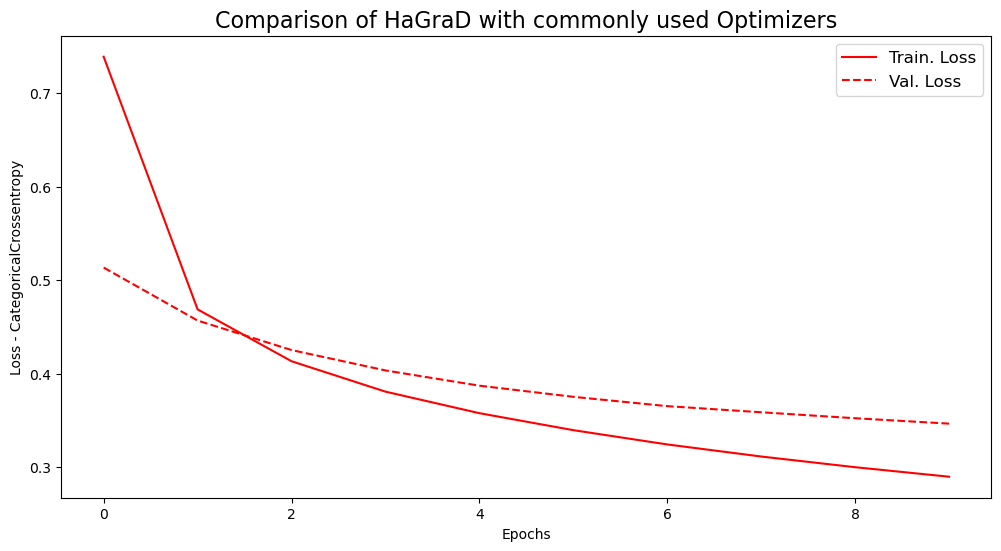

In [30]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("Comparison of HaGraD with commonly used Optimizers", fontsize=16)
ax.plot(loss_history,     "-r", label="Train. Loss")
ax.plot(val_loss_history, "--r", label=  "Val. Loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss - CategoricalCrossentropy")
leg = ax.legend(frameon=True, fontsize=12)
plt.show()
plt.close()